# This is a reference for maximum iteration selection whenever necessary. 

See the figures attached below for details.

In [1]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.special import betaln, gammaln
from scipy.stats import binom
import time

In [2]:
data = sm.datasets.star98.load()

exog = data.exog
endog = data.endog.to_numpy()
exog = sm.add_constant(exog, prepend = False)
exog

,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,PTRATIO,PCTAF,...,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF,const
0,34.39730,23.299300,14.235280,11.411120,15.918370,14.70646,59.15732,4.445207,21.71025,57.03276,...,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352,1.0
1,17.36507,29.328380,8.234897,9.314884,13.636360,16.08324,59.50397,5.267598,20.44278,64.62264,...,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468,1.0
2,32.64324,9.226386,42.406310,13.543720,28.834360,14.59559,60.56992,5.482922,18.95419,53.94191,...,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777,1.0
3,11.90953,13.883090,3.796973,11.443110,11.111110,14.38939,58.33411,4.165093,21.63539,49.06103,...,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568,1.0
4,36.88889,12.187500,76.875000,7.604167,43.589740,13.90568,63.15364,4.324902,18.77984,52.38095,...,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,62.23968,13.820860,3.956157,32.128790,15.884480,13.27089,52.88133,4.324174,20.98711,8.00000,...,18.181820,210.801187,839.99243,701.7823,90.75192,34.59339,167.8969,11147.4471,726.0153,1.0
299,46.16188,1.150575,0.800400,45.622810,13.333330,11.80714,48.42615,3.945069,19.85830,53.77358,...,0.000000,157.428494,645.68184,571.7743,78.34236,212.14048,1067.8519,7623.6559,4212.7494,1.0
300,43.41431,3.648564,1.541204,46.319980,21.377670,14.40468,53.79616,3.845481,22.70884,29.89247,...,6.666667,307.938495,1150.03656,774.9165,87.32641,114.95093,678.8233,16565.9086,2610.4022,1.0
301,70.62104,20.461720,2.989345,17.423050,11.032860,16.56420,61.70566,3.970984,24.88647,15.14286,...,13.636360,182.750500,680.78991,1022.1049,98.82377,60.13205,376.8523,11276.7402,1496.4746,1.0


In [3]:
def sigmoid(x):
    a = []
    for i in np.nditer(x):
        if i >= 0:
            a.append(1.0/(1+math.exp(-i)))
        else:
            a.append(math.exp(i)/(1+math.exp(i)))
    return np.array(a)

def cost_fun_for_W(W, endog, exog, phi):
    Z = sigmoid(np.inner(W, exog)) #change to np.inner(W, exog) from np.dot(exog, W)
    k = np.array(endog[:, 0])
    n = np.array(endog[:, 0] + endog[:, 1])
    a = Z * (1/phi - 1)
    b = (1 - Z) * (1/phi - 1)
    cost = np.sum(betaln(k + a, n - k + b) - betaln(a, b))
    return -(cost/np.size(Z))

def cost_fun_for_phi(phi, endog, exog, W):
    Z = sigmoid(np.inner(W, exog)) #change to np.inner(W, exog) from np.dot(exog, W)
    k = np.array(endog[:, 0])
    n = np.array(endog[:, 0] + endog[:, 1])
    a = Z * (1/phi - 1)
    b = (1 - Z) * (1/phi - 1)
    cost = np.sum(betaln(k + a, n - k + b) - betaln(a, b))
    return -(cost/np.size(Z))

#def fit(self):
   # W = np.array([0, 0])
    #phi = 0.1
    #bounds_phi = [(0, 1)]
    #res1 = minimize(fun = cost_fun_for_phi, x0 = phi, args = (self.endog, self.exog, W), bounds = bounds_phi, method = 'Nelder-Mead')
    #phi = res1.x
    #bounds_W = [(-np.inf, np.inf), (-np.inf, np.inf)]
    #res2 = minimize(fun = cost_fun_for_W, x0 = W, args = (self.endog, self.exog, phi), bounds = bounds_W, method = 'Nelder-Mead')
    #W = np.array(res2.x)
    #return res1.x, res2.x

def predict(self):
    W = self.W
    Z = sigmoid(np.dot(self.exog, W))
    n = np.array(self.endog[:, 0] + self.endog[:, 1])
    pred = [(Z[i] * n[i], (1 - Z[i]) * n[i]) for i in range (len(Z))]
    ypred = np.array(pred)
    return ypred

def get_loglikelihood(self):
    W = self.W
    phi = self.phi
    Z = sigmoid(np.dot(self.exog, W))
    k = np.array(self.endog[:, 0])
    n = np.array(self.endog[:, 0] + self.endog[:, 1])
    a = Z * (1/phi - 1)
    b = (1 - Z) * (1/phi - 1)
    return np.sum(betaln(k + a, n - k + b) - betaln(a, b)) + np.sum(gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1))

def fit_trial(self, phi, W):
    #print(np.shape(W))
    bounds_W = [(-np.inf, np.inf) for i in range (self.exog.shape[1])] 
    if self.maxiter == 0: 
        res1 = minimize(fun = cost_fun_for_W, x0 = W, args = (self.endog, self.exog, phi), bounds = bounds_W, method = 'Nelder-Mead') 
    else:
        res1 = minimize(fun = cost_fun_for_W, x0 = W, args = (self.endog, self.exog, phi), bounds = bounds_W, method = 'Nelder-Mead', options = {'maxiter': self.maxiter*self.exog.shape[1]})  
    W = res1.x
    bounds_phi = [(0, 1)]
    res2 = minimize(fun = cost_fun_for_phi, x0 = phi, args = (self.endog, self.exog, W), bounds = bounds_phi, method = 'Nelder-Mead', options = {'maxiter': 5}) 
    return res1.x, res2.x
    
def get_LL(self,W, phi):
    Z = sigmoid(np.dot(self.exog, W))
    k = np.array(self.endog[:, 0])
    n = np.array(self.endog[:, 0] + self.endog[:, 1])
    a = Z * (1/phi - 1)
    b = (1 - Z) * (1/phi - 1)
    return np.sum(betaln(k + a, n - k + b) - betaln(a, b)) + np.sum(gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1))

def fit(self):
    phi = 0.1
    #print(np.shape(self.exog))
    W = np.array([0 for i in range (self.exog.shape[1])])
    #print(np.shape(exog))
    start_time = time.time()
    NLL_trend = []
    cnt = 0 
    while True:
        if (len(NLL_trend) > 1):
            if (abs(NLL_trend[-1] - NLL_trend[-2]) < 1e-7):
                break
        cnt += 1
        W, phi = fit_trial(self, phi, W)
        #print(f'iteration times: {cnt}, W: {W}, phi: {phi}', end = '\r')
        NLL_trend.append(-get_LL(self, W, phi))
    end_time = time.time()
    total_time = end_time - start_time
    return W, phi, NLL_trend, total_time

In [4]:
class BetaBinomial():
    def __init__(self, endog, exog, maxiter = 50):
        exog = sm.add_constant(exog, prepend = False)
        self.exog = exog
        self.endog = endog
        self.maxiter = maxiter
        self.W, self.phi, self.NLL_trend, self.time = fit(self)
        #self.phi, self.W = fit(self)
        self.predict = predict(self)
        self.loglikelihood = get_loglikelihood(self)

In [5]:
iter_time = [5, 10, 25, 50, 100, 200, 500]
def test_iter(x):
    col_name = exog.columns.to_list()
    #print(len(col_name))
    result_with_maxiter = {}
    exog0 = pd.DataFrame()
    NLL = []
    time_cost = []
    for i in range (len(col_name)):
        print(x, i, end = '\r')
        exog0.insert(0, col_name[i], exog[col_name[i]])
        #print(exog0)
        mod = BetaBinomial(endog, exog0, x)
        NLL.append(-mod.loglikelihood)
        time_cost.append(mod.time)
        #print(NLL)
    return NLL, time_cost

In [6]:
NLL_5, time_cost_5 = test_iter(5)
NLL_5, time_cost_5

([1563.7060885432875,
  1633.3809099213977,
  1532.7738510316121,
  1509.2834643637761,
  1508.8136268933886,
  1506.8185058727977,
  1507.205337716994,
  1518.581656870083,
  1503.1424468834884,
  1520.2505361835356,
  1523.4836190523347,
  1520.2513648528256,
  1493.6011138013564,
  1511.8403036595555,
  1495.759044096223,
  1512.9347607785603,
  1507.901508548588,
  1508.9125826760428,
  1495.404647922318,
  1493.3064989085833,
  1493.3064989085833],
 [0.1663672924041748,
  0.05458831787109375,
  0.2580850124359131,
  0.36536288261413574,
  1.3199639320373535,
  2.9639599323272705,
  5.1988630294799805,
  3.1041438579559326,
  1.5309691429138184,
  7.311998128890991,
  4.612066030502319,
  5.678934097290039,
  15.005095958709717,
  36.023154973983765,
  36.42293930053711,
  24.061269998550415,
  38.4569571018219,
  17.333189249038696,
  22.54612898826599,
  26.250083923339844,
  26.449455738067627])

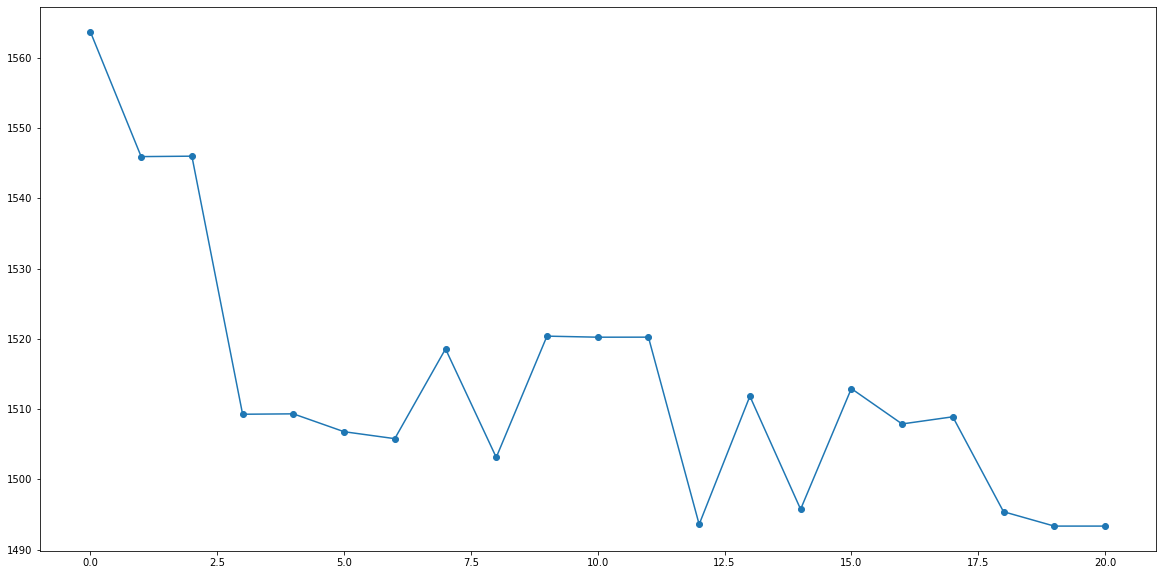

In [17]:
fig = plt.subplots(figsize = (20, 10))
x = [i  for i in range (20 + 1)]
plt.plot(x, NLL_5, 'o-', label="NLL when maxiter = 5")

In [18]:
NLL_10, time_cost_10 = test_iter(10)

<ipython-input-5-7d84ac8e9052>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-5-7d84ac8e9052>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


In [19]:
NLL_25, time_cost_25 = test_iter(25)

<ipython-input-5-7d84ac8e9052>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-5-7d84ac8e9052>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


In [7]:
NLL_50, time_cost_50 = test_iter(50)

<ipython-input-1-15afa4e543d7>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-1-15afa4e543d7>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


In [21]:
NLL_100, time_cost_100 = test_iter(100)

<ipython-input-5-7d84ac8e9052>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-5-7d84ac8e9052>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


<ipython-input-5-7d84ac8e9052>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-5-7d84ac8e9052>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


In [10]:
NLL_200, time_cost_200 = test_iter(200)

<ipython-input-1-b77f4739d951>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-1-b77f4739d951>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


<ipython-input-1-b77f4739d951>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-1-b77f4739d951>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


In [24]:
NLL_500, time_cost_500 = test_iter(500)

<ipython-input-5-7d84ac8e9052>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-5-7d84ac8e9052>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


<ipython-input-5-7d84ac8e9052>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-5-7d84ac8e9052>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


In [36]:
col_name = exog.columns.to_list()
#print(len(col_name))
result_with_maxiter = {}
exog0 = pd.DataFrame()
NLL_auto = []
time_cost_auto = []
for i in range (len(col_name)):
    print(i, end = '\r')
    exog0.insert(0, col_name[i], exog[col_name[i]])
    #print(exog0)
    mod = BetaBinomial(endog, exog0)
    NLL_auto.append(-mod.loglikelihood)
    time_cost_auto.append(mod.time)
    #print(NLL)

<ipython-input-34-e390bd972b2a>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-34-e390bd972b2a>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


<ipython-input-34-e390bd972b2a>:23: RuntimeWarning: divide by zero encountered in true_divide
  a = Z * (1/phi - 1)
<ipython-input-34-e390bd972b2a>:24: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - Z) * (1/phi - 1)


# Plot out the relationship between the number of parameters and negative log likelihood given different iteration times.

### "NLL when maxiter = 5" shows the negative log likelihood when maximum iteration equals to 5*(number of parameters) 

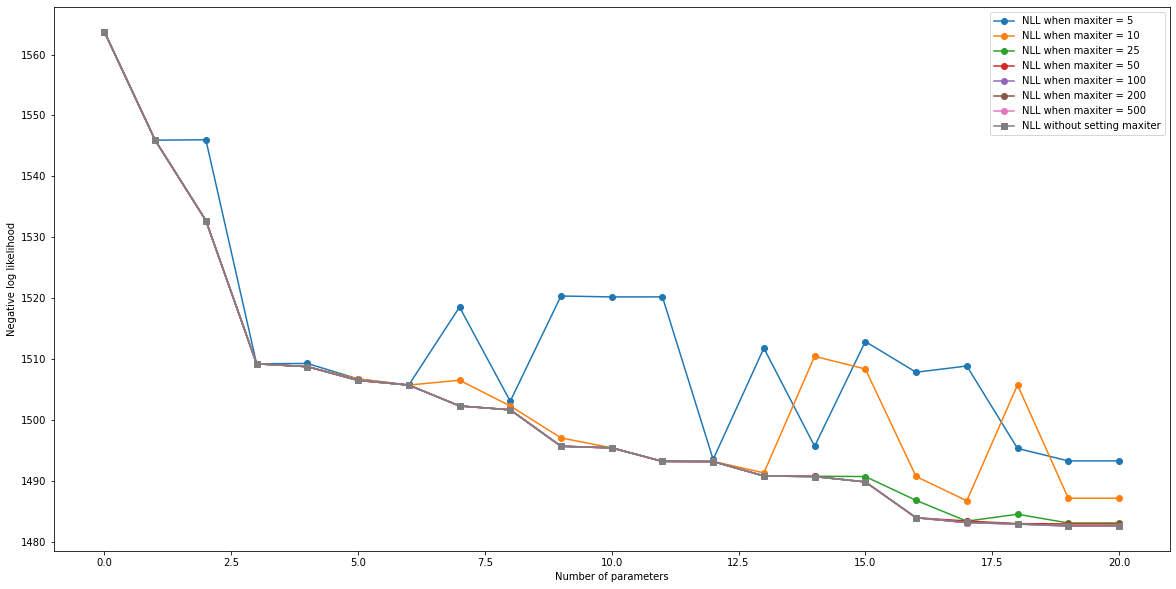

In [44]:
fig = plt.subplots(figsize = (20, 10))
x = [i  for i in range (20 + 1)]
k1 = [NLL_5[i] for i in range (20+1)]
k2 = [NLL_10[i] for i in range (20+1)]
k3 = [NLL_25[i] for i in range (20+1)]
k4 = [NLL_50[i] for i in range (20+1)]
k5 = [NLL_100[i] for i in range (20+1)]
k6 = [NLL_200[i] for i in range (20+1)]
k7 = [NLL_500[i] for i in range (20+1)]
k8 = [NLL_auto[i] for i in range (20+1)]
plt.plot(x,k1, 'o-', label="NLL when maxiter = 5")
plt.plot(x,k2, 'o-', label="NLL when maxiter = 10")
plt.plot(x,k3, 'o-', label="NLL when maxiter = 25")
plt.plot(x,k4, 'o-', label="NLL when maxiter = 50")
plt.plot(x,k5, 'o-', label="NLL when maxiter = 100")
plt.plot(x,k6, 'o-', label="NLL when maxiter = 200")
plt.plot(x,k7, 'o-', label="NLL when maxiter = 500")
plt.plot(x,k8, 's-', label='NLL without setting maxiter')
plt.plot()
plt.xlabel("Number of parameters")
plt.ylabel("Negative log likelihood")
plt.legend(loc = "best")
plt.show()

# Plot out the relationship between the number of parameters and time need to finish the optimization given different iteration times.

### "NLL when maxiter = 5" shows the time needed when maximum iteration equals to 5*(number of parameters) 

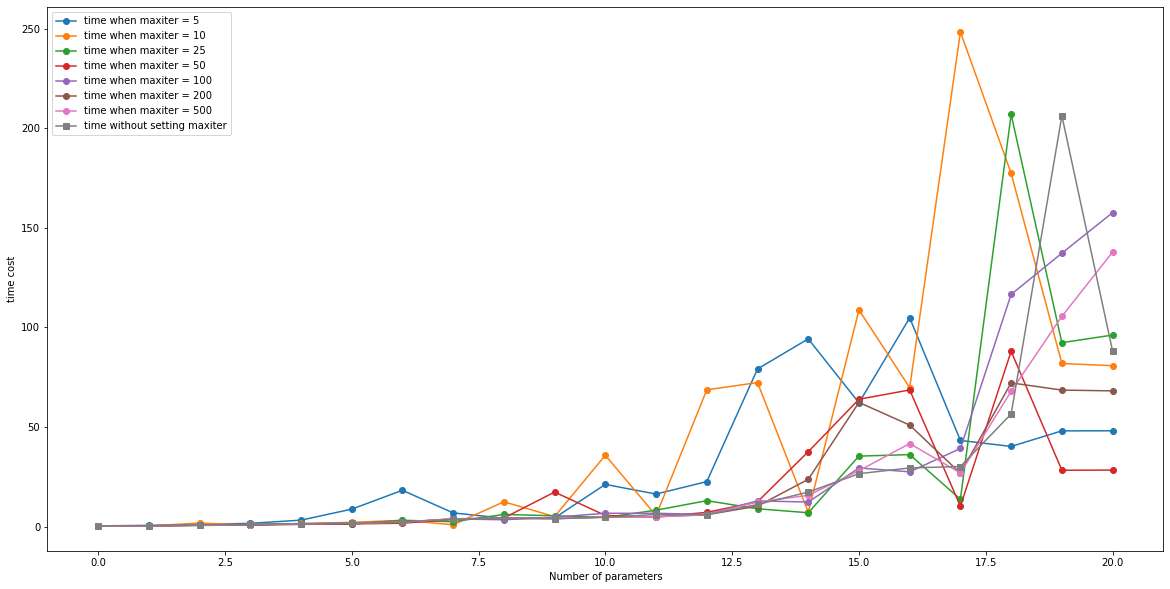

In [45]:
fig = plt.subplots(figsize = (20, 10))
x = [i  for i in range (20 + 1)]
k1 = [time_cost_5[i] for i in range (20+1)]
k2 = [time_cost_10[i] for i in range (20+1)]
k3 = [time_cost_25[i] for i in range (20+1)]
k4 = [time_cost_50[i] for i in range (20+1)]
k5 = [time_cost_100[i] for i in range (20+1)]
k6 = [time_cost_200[i] for i in range (20+1)]
k7 = [time_cost_500[i] for i in range (20+1)]
k8 = [time_cost_auto[i] for i in range (20+1)]
plt.plot(x,k1, 'o-', label="time when maxiter = 5")
plt.plot(x,k2, 'o-', label="time when maxiter = 10")
plt.plot(x,k3, 'o-', label="time when maxiter = 25")
plt.plot(x,k4, 'o-', label="time when maxiter = 50")
plt.plot(x,k5, 'o-', label="time when maxiter = 100")
plt.plot(x,k6, 'o-', label="time when maxiter = 200")
plt.plot(x,k7, 'o-', label="time when maxiter = 500")
plt.plot(x,k8, 's-', label='time without setting maxiter')
plt.plot()
plt.xlabel("Number of parameters")
plt.ylabel("time cost")
plt.legend(loc = "best")
plt.show()